# Data Augmentations on Images with code Implementation + Test Time Imagenet Augmentations

In this post, I will focus on single example data augmentations on images. For each augmentation, I will provide the implementation details and explanation of that augmentation. In the next post, I will talk about multi-example data augmentations like Cutmix, mixup, RICAP, and their variations.

In [ ]:
import torch
import PIL
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from io import BytesIO
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Utility functions that I would use throughout the notebook.

In [ ]:
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

def load_img(path):
    """
    This would return a [channel, height, width] image as a PyTorch tensor.
    Also, the image return would be [0,1] normalized i.e the max value in 
    the image would be 1 and the minimum value would be 0.
    """
    x =  PIL.Image.open(path)
    return pil2tensor(x)    

def show_img(x):
    f = BytesIO()
    x = np.uint8(x.mul(255).numpy().transpose(1,2,0))
    PIL.Image.fromarray(x).save(f, 'png')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
def apply_tfm_on_list(tfm, img, vals=[.0, .2, .4, .6, .8, 1.], nrow=None):
    imgs = []
    for val in vals:
        x = img.clone()
        imgs.append(tfm(x, val))
    imgs = torch.stack(imgs)
    
    if nrow is None:
        nrow=len(vals)
    grid_image = make_grid(imgs, nrow=nrow)
    show_img(grid_image)

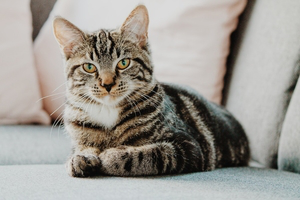

Image Size: torch.Size([3, 200, 300])
Image Type: torch.float32


In [ ]:
img = load_img('images/cat.jpg')
show_img(img)

print(f'Image Size: {img.size()}')
print(f'Image Type: {img.dtype}')

## Index of Transforms
1. Brightness
2. Contrast
3. Padding
    1. Zero padding
    2. Border padding
    3. Reflection padding
4. Affine Transformations
    1. Rotate
    2. Zoom
    3. Squish
    4. 

### Some Details
1. In PyTorch when you work with images remember to clone your image and then do your operations otherwise both tensors would point to the same object and we don't want to modify the original image as we want to keep working with it later. You can do this using the clone method, `img_copy = img.clone()`.
2. By default all the functions that I will write for the transforms, I would assume the input image is a pytorch tensor with the dimensions (channel, height, width). Also, the images would be [0,1] normalized.
3. Most humans do not perceive all the channels in an RGB image equally. We do not have the same sensitivity for all the three channels. So in case you want to convert your RGB images to grayscale instead of taking the average of the three channels you can use these coefficients `gray_image = 0.4*red_channel + 0.4*green_channel + 0.2*blue_image`. You can check this [link](https://www.wikiwand.com/en/Grayscale#/Colorimetric_.28luminance-preserving.29_conversion_to_grayscale) for more info.

### 1. Brightness
It refers to the whiteness in the image. Best way to see the effect of brightness is to increase the brightness of your monitor. As you increase the brightness you can see the increase in the whiteness (technically it is called luminance). When the brightness is too high the whitest pixels become saturated, destroying detail in these areas (due to the increase in the [255,255,255] pixels in that area).

To change the brightness of an image, you need to multiply the pixels by a scalar. So to increase the brightness the scalar should be greater than 1 and to decrease the brightness the scalar should be less than 1. After doing this operation you also need to clamp your values so that the pixel values lie between 0 and 1.

An intuitive explanation for multiplying by a scalar can be, we want to maintain the same image as the original one. By multiplying we are essentially keeping the same image as we are just scaling the pixel values. Also (255,255,255) is the RGB value of white, so by multiplying by a scalar we are making our pixel values closer to this value.

In [ ]:
def brightness(img, val=0.4):
    # val=1.0 would give the original image
    x = img.clone()
    
    x.mul_(val)
    x = torch.clamp(x, 0, 1)
    return x

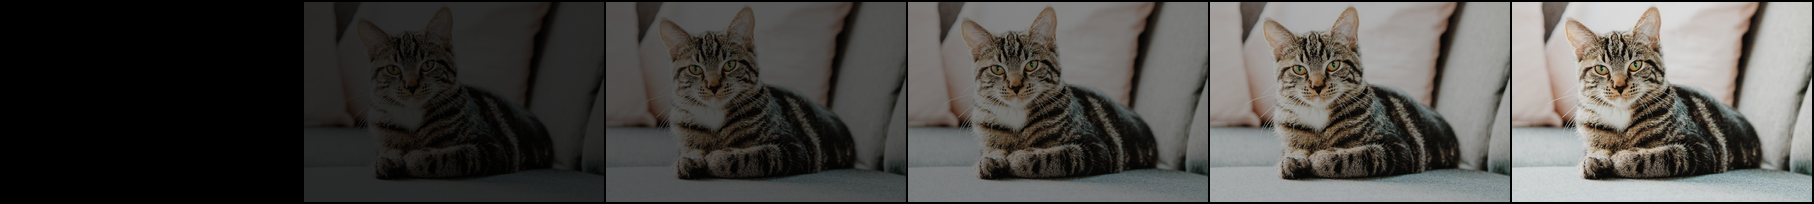

In [ ]:
apply_tfm_on_list(brightness, img)

### 2. Contrast
Contrast is the difference in brightness between objects or regions. For example, a white rabbit running across a snowy field has poor contrast, while a black dog against the same white background has a good contrast. When contrast is too high blacks become too black and the whites become too white.

To change the contrast of an image you need to add a scalar to the image. As our images are [0,1] normalized we add a scalar value that is between -1 and 1. But to keep notation consistent I use a scalar that is between 0 and 1, where 0 means low contrast and 1 means high contrast.

In [ ]:
def contrast(img, val=0.5):
    # val=0.5 would give the original image
    val = 2*val - 1
    x = img.clone()
    
    x.add_(val)
    x = torch.clamp(x, 0, 1)
    return x

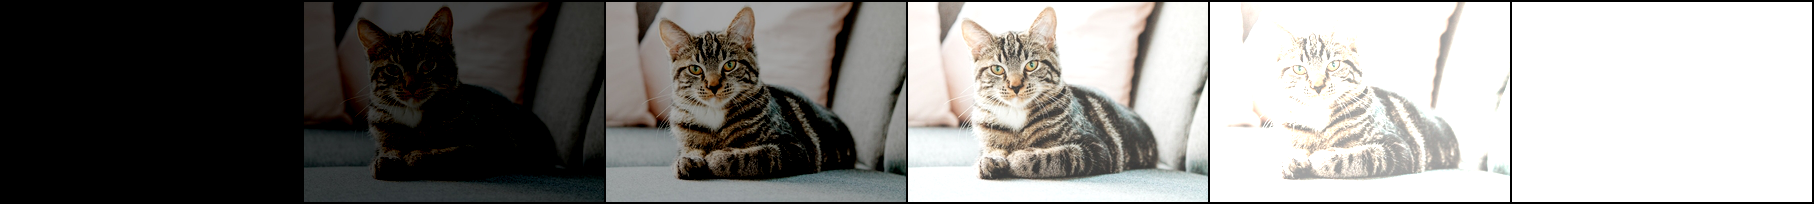

In [ ]:
apply_tfm_on_list(contrast, img)

### 3. Padding
There are mainly three types of padding that you can use for your input layers, _zero_padding, border padding, reflection padding_. For the best results use reflection padding and it is also the default padding in [fastai](https://docs.fast.ai/) as well.

Why padding is important? It allows us to design deeper networks, as we can maintain the same input dimension after every layer. If the inputs were not padded then the information at the borders would be washed away too quickly. By using padding, we can keep the information at borders for more number of layers. Padding is also important when we need to concatenate conv layers with different kernel sizes, like in inception module.

Another reason why padding is important is because when we do some affine transformations on our images like rotate them, some part of the image misses out and we have to use padding to fill that part.

#### 3.1 Zero Padding
In this padding technique, we add zero pixels at the borders of the input tensor. Zero padding is kind of ok but if suffers from edge effects, where your images suddenly becomes black. For general cases like classification, object detection this is not much of a problem but when you are looking at biological tissue which can have more of a "texture" quality than "object: quality zero padding is a bad choice. The reason being zero padding introduces edge effects, so instead use Reflection padding in that case.

To implement it create a new zero tensor with the required size and then copy your image to it. To define the size of the padding use this format `[col_pad, row_pad]` and these padding sizes are multiplied by 2 for each border. If input size of image is (200, 300) and padding size is (3, 4), the resulting image would have a size of (206, 308).

In [ ]:
def zero_pad(img, size=[0]):
    if len(size) == 1:
        col = row = size[0]
    elif len(size) == 2:
        col = size[0]
        row = size[1]
    else:
        raise Exception
        
    new_col = img.size(1) + col*2
    new_row = img.size(2) + row*2
    
    x = torch.zeros(img.size(0), new_col, new_row, dtype=img.dtype, device=img.device, requires_grad=img.requires_grad)
    
    x[:, col:new_col-col, row:new_row-row] = img
    return x

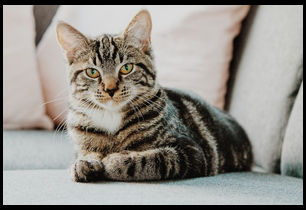

In [ ]:
x = zero_pad(img, size=[5, 3])
show_img(x)

#### 3.2 Border/Edge Padding
Pad with the last value at the edge of the image. If my input is [1, 2, 3, 4, 5] and use border padding = 3 the result would be [1, 1, 1, 1, 2, 3, 4, 5, 5, 5].

See the below picture for the implementation details. To code this function, I make cases and copy the data in that order.

<img src='images/border_pad.jpg'>

In [ ]:
def border_pad(img, size=[0]):
    c, h, w = img.size()
    if len(size) == 1:
        col = row = size[0]
    elif len(size) == 2:
        col = size[0]
        row = size[1]
    else:
        raise Exception
    
    new_col = h + 2*col
    new_row = w + 2*row
    x = torch.zeros(c, new_col, new_row, dtype=img.dtype, device=img.device, requires_grad=img.requires_grad)
    
    # We have to make cases and copy the tensor in that way
    # For [0,0] corner
    x[:, :col, :row] = img[:, 0, 0].reshape(c, 1, 1)
    
    # For [1, 0] corner
    x[:, new_col-col:, :row] = img[:, -1, 0].reshape(c, 1, 1)
    
    # For [0, 1] corner
    x[:, :col, new_row-row:] = img[:, 0, -1].reshape(c, 1, 1)
    
    # For [1,1] corner
    x[:, new_col-col:, new_row-row:] = img[:, -1, -1].reshape(c, 1, 1)
    
    # For left row
    x[:, col:new_col-col, :row] = img[:, :, 0].reshape(c, h, 1)
    
    # For right column
    x[:, col:new_col-col, new_row-row:] = img[:, :, -1].reshape(c, h, 1)
    
    # For top row
    x[:, :col, row:new_row-row] = img[:, 0, :].reshape(c, 1, w)
    
    # For bottom row
    x[:, new_col-col:, row:new_row-row] = img[:, -1, :].reshape(c, 1, w)
    
    # For center part
    x[:, col:new_col-col, row:new_row-row] = img
    
    return x

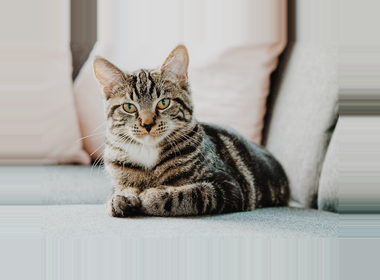

In [ ]:
x = border_pad(img, size=[40])
show_img(x)

#### 3.2 Reflection pad
Pads with reflection of the image without repeating the last value on the edge.For example, padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode will result in [3, 2, 1, 2, 3, 4, 3, 2]. There is another variation of this padding called __symmetric__ where the last edge of the image is also repeated. I focus on Reflection pad here. By default Reflection pad wherever possible. 

There are some technical details as to why you should use reflection padding over zero padding, mostly having to do with brightness and contrast histograms. But one of the main benefits of reflection padding is it does not introduce edge effects as in the case of zero padding.

Check the below figure on intuition behind the approach. Like border pad, to implement it I would make cases and copy the image.

<img src='images/reflection_pad.jpg'>

In [ ]:
def reflect_pad(img, size=[0]):
    c, h, w = img.size()
    if len(size) == 1:
        col = row = size[0]
    elif len(size) == 2:
        col = size[0]
        row = size[1]
    else:
        raise Exception
        
    new_col = h + 2*col
    new_row = w + 2*row
    x = torch.zeros(c, new_col, new_row, dtype=img.dtype, device=img.device, requires_grad=img.requires_grad)
    
    # For [0, 0] corner
    x[:, :col, :row] = img[:, 1:col+1, 1:row+1].flip(1, 2)
    
    # For [0, 1] corner
    x[:, :col, new_row-row:] = img[:, 1:col+1, w-row-1:-1].flip(1, 2)
    
    # For [1, 0] corner
    x[:, new_col-col:,:row] = img[:, h-col-1:-1, 1:row+1].flip(1, 2)
    
    # For [1, 1] corner
    x[:, new_col-col:, new_row-row:] = img[:, h-col-1:-1, w-row-1:-1].flip(1, 2)
    
    # For top row
    x[:, :col, row:new_row-row] = img[:, 1:col+1, :].flip(1)
    
    # For bottom row
    x[:, new_col-col:, row:new_row-row] = img[:, h-col-1:-1, :].flip(1)
    
    # For left column
    x[:, col:new_col-col, :row] = img[:, :, 1:row+1].flip(2)
    
    # For right column
    x[:, col:new_col-col, new_row-row:] = img[:, :, w-row-1:-1].flip(2)
    
    # For center image
    x[:, col:new_col-col, row:new_row-row] = img
    
    return x

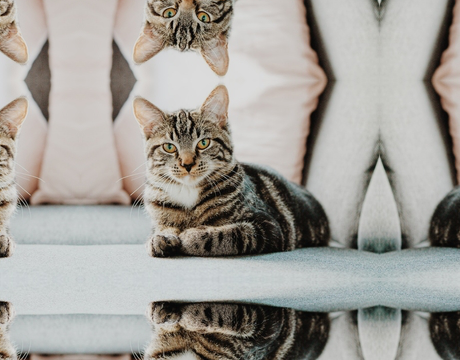

In [ ]:
x = reflect_pad(img, size=[80])
show_img(x)

### 4. Affine Transformations
Affine transformations preserves points, straight lines and planes in an image. Set of parallel lines remain parallel after an affine transformation. An affine transformation does not necessarily preserve angles between angles between lines or distances between points, though it does preserve ratios of distances between points lying on a straight line.

The implementation of Affine Transformation is just a matrix product with the original image. I do not go into the details of the derivations of these formulas as they are standard results.

#### 4.1 Horizontal and Vertical flip
This transform is very simple. You can use Horizontal flipping in all of the computer vision tasks, but you should use Vertical flipping only when the flipped images make sense in your dataset. For example, the vertical flipping of a cat image does not make much sense, as in the real world we would see cats with head up. But in cases of satellite images we can use Vertical flipping as the images produce resemble the dataset.

The matrix to implement Horizontal flipping is 
```python
[-1 0 0]
[ 0 1 0]
[ 0 0 1]
```

The matrix to implement Vertical flipping is


In [ ]:
def flip(img, hort=True, vert=False):
    x = img.clone()
    if hort:
        x = torch.mm(torch.Tensor([[[-1, 0, 0], [0, 1, 0], [0, 0, 1]]]),  x)
    return x

In [ ]:
show_img(flip(img))

RuntimeError: matrices expected, got 3D, 3D tensors at /opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/TH/generic/THTensorMath.cpp:747

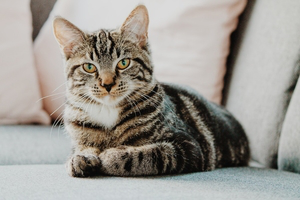

In [ ]:
x = torch.Tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x1 = img.reshape(3, -1)

temp = x @ x1
temp = temp.reshape(3, 200, 300)

show_img(temp)

In [ ]:
def affine_grid(size=(200,300)):
    h, w = size
    grid = torch.FloatTensor(h, w, 2)
    linear_points = torch.linspace(-1, 1, w)
    grid[:, :, 0] = torch.ger(torch.ones(h), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1, 1, h)
    grid[:, :, 1] = torch.ger(linear_points, torch.ones(w)).expand_as(grid[:, :, 1])
    return grid

def grid_sample(img, coords, mode='bilinear', padding_mode='reflection', remove_out=True):
    coords = coords.permute(2, 0, 1).contiguous().permute(1, 2, 0)
    if mode == 'bilinear':
        min, max = coords.min(), coords.max()

In [ ]:
a = torch.rand(10, 3, 100, 200)
c = 3
h = 100
w = 200
n = 10

a.size()

torch.Size([10, 3, 100, 200])

In [ ]:
x1 = a.permute(0, 3, 1, 2)
x1.size()

torch.Size([10, 200, 3, 100])

In [ ]:
x2 = x1.contiguous()
x2.size()

torch.Size([10, 200, 3, 100])

In [ ]:
x3 = x2.permute(0, 2, 3, 1)
x3.size()

torch.Size([10, 3, 100, 200])

In [ ]:
torch.equal(x3, a)

True